In [56]:
import sys
import os

# Add the parent directory of src to the system path
sys.path.append(os.path.abspath('../src'))


from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
#from numba import jit,prange
from model.model import GCN

import time
import utils as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error',
          'r2' : 'r2'} 

In [57]:
def runs(dx, max_m):
    # FOR HEAD MOTION
    merged_df,merged_phenotypic  = ut.read_motion()

    # Health subjects
    merged_phenotypic = merged_phenotypic[merged_phenotypic['DX'] == dx]
    merged_phenotypic = merged_phenotypic[merged_phenotypic[' Max Rotation (degree)'] < max_m]
    merged_phenotypic = merged_phenotypic[merged_phenotypic['Max Motion (mm)'] < max_m]


    #merged_df = merged_df.set_index(['Institution', 'Subject', 'Run'])
    #merged_phenotypic = merged_phenotypic.set_index(['Institution', 'Subject', 'Run'])
    common_indices = merged_df.index.intersection(merged_phenotypic.index)
    merged_phenotypic = merged_phenotypic.loc[common_indices,:]
    merged_df = merged_df.loc[common_indices,:]
    merged_df = merged_df.reset_index()
    merged_phenotypic = merged_phenotypic.reset_index()


    X_fmri = merged_df.iloc[:,14:]

    # Shuffle
    #X_fmri = X_fmri.sample(frac=1, axis=1)  # `frac=1` means to return all columns

    y = merged_df['Max Motion (mm)']
    y = merged_phenotypic['Age']


    A = ut.reconstruct_symmetric_matrix(190, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(190, 3).to(device)
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190.pth'))
    #model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_TRUE.pth'))
    model.load_state_dict(torch.load('/Users/rodrigo/Post-Grad/Ising_GNN/Data/model_params_190_mae.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df_dx = pd.concat([merged_phenotypic[['Institution','Subject','Run','Max Motion (mm)', ' Max Rotation (degree)','Gender', 'DX']],
                        y],axis=1)

    df_dx = df_dx.dropna()
    return df_dx

In [58]:
def adhd_ingestion(dx=None, max_m=3):
    # ADHD 333
    df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
    N = 333

    if dx != None:
        if dx == 0:
        # Health subjects
            df = df[df['DX'] == dx]
        if dx == 1: 
        # ADHD Symptoms
            df = df[df['DX'] != 0]

    df = df[df[' Max Rotation (degree)'] < max_m]
    df = df[df['Max Motion (mm)'] < max_m]
    
    X_fmri = df.iloc[:,1:-37]

    y = df['Age']
    
    A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
    train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y, size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = GCN(N, 3).to(device)
    model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Thesis/model_params_333_TRUE.pth'))

    model.eval()

    y_pred_aux_age = []
    for y_i in val_loader:
        y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

    # my_dict_age = {}
    # for i in range(len(y.values)):
    #     my_dict_age[y.values[i]] = y_pred_aux_age[i]

    y = pd.DataFrame(y)
    y['Temperature'] = y_pred_aux_age

    df = pd.concat([df[['Institution','Subject','Max Motion (mm)', ' Max Rotation (degree)','Gender']], #'Run'
                        y],axis=1)

    df = df.dropna()
    
    return df
    

In [59]:
df = adhd_ingestion(dx=0, max_m=1.5)

df['Temperature'] = df['Temperature'] - 2.23
#df = fisher(dx=0, max_m=1)
#df = runs(dx=0, max_m=5)

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_88478/3861590456.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_88478/3861590456.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.ad

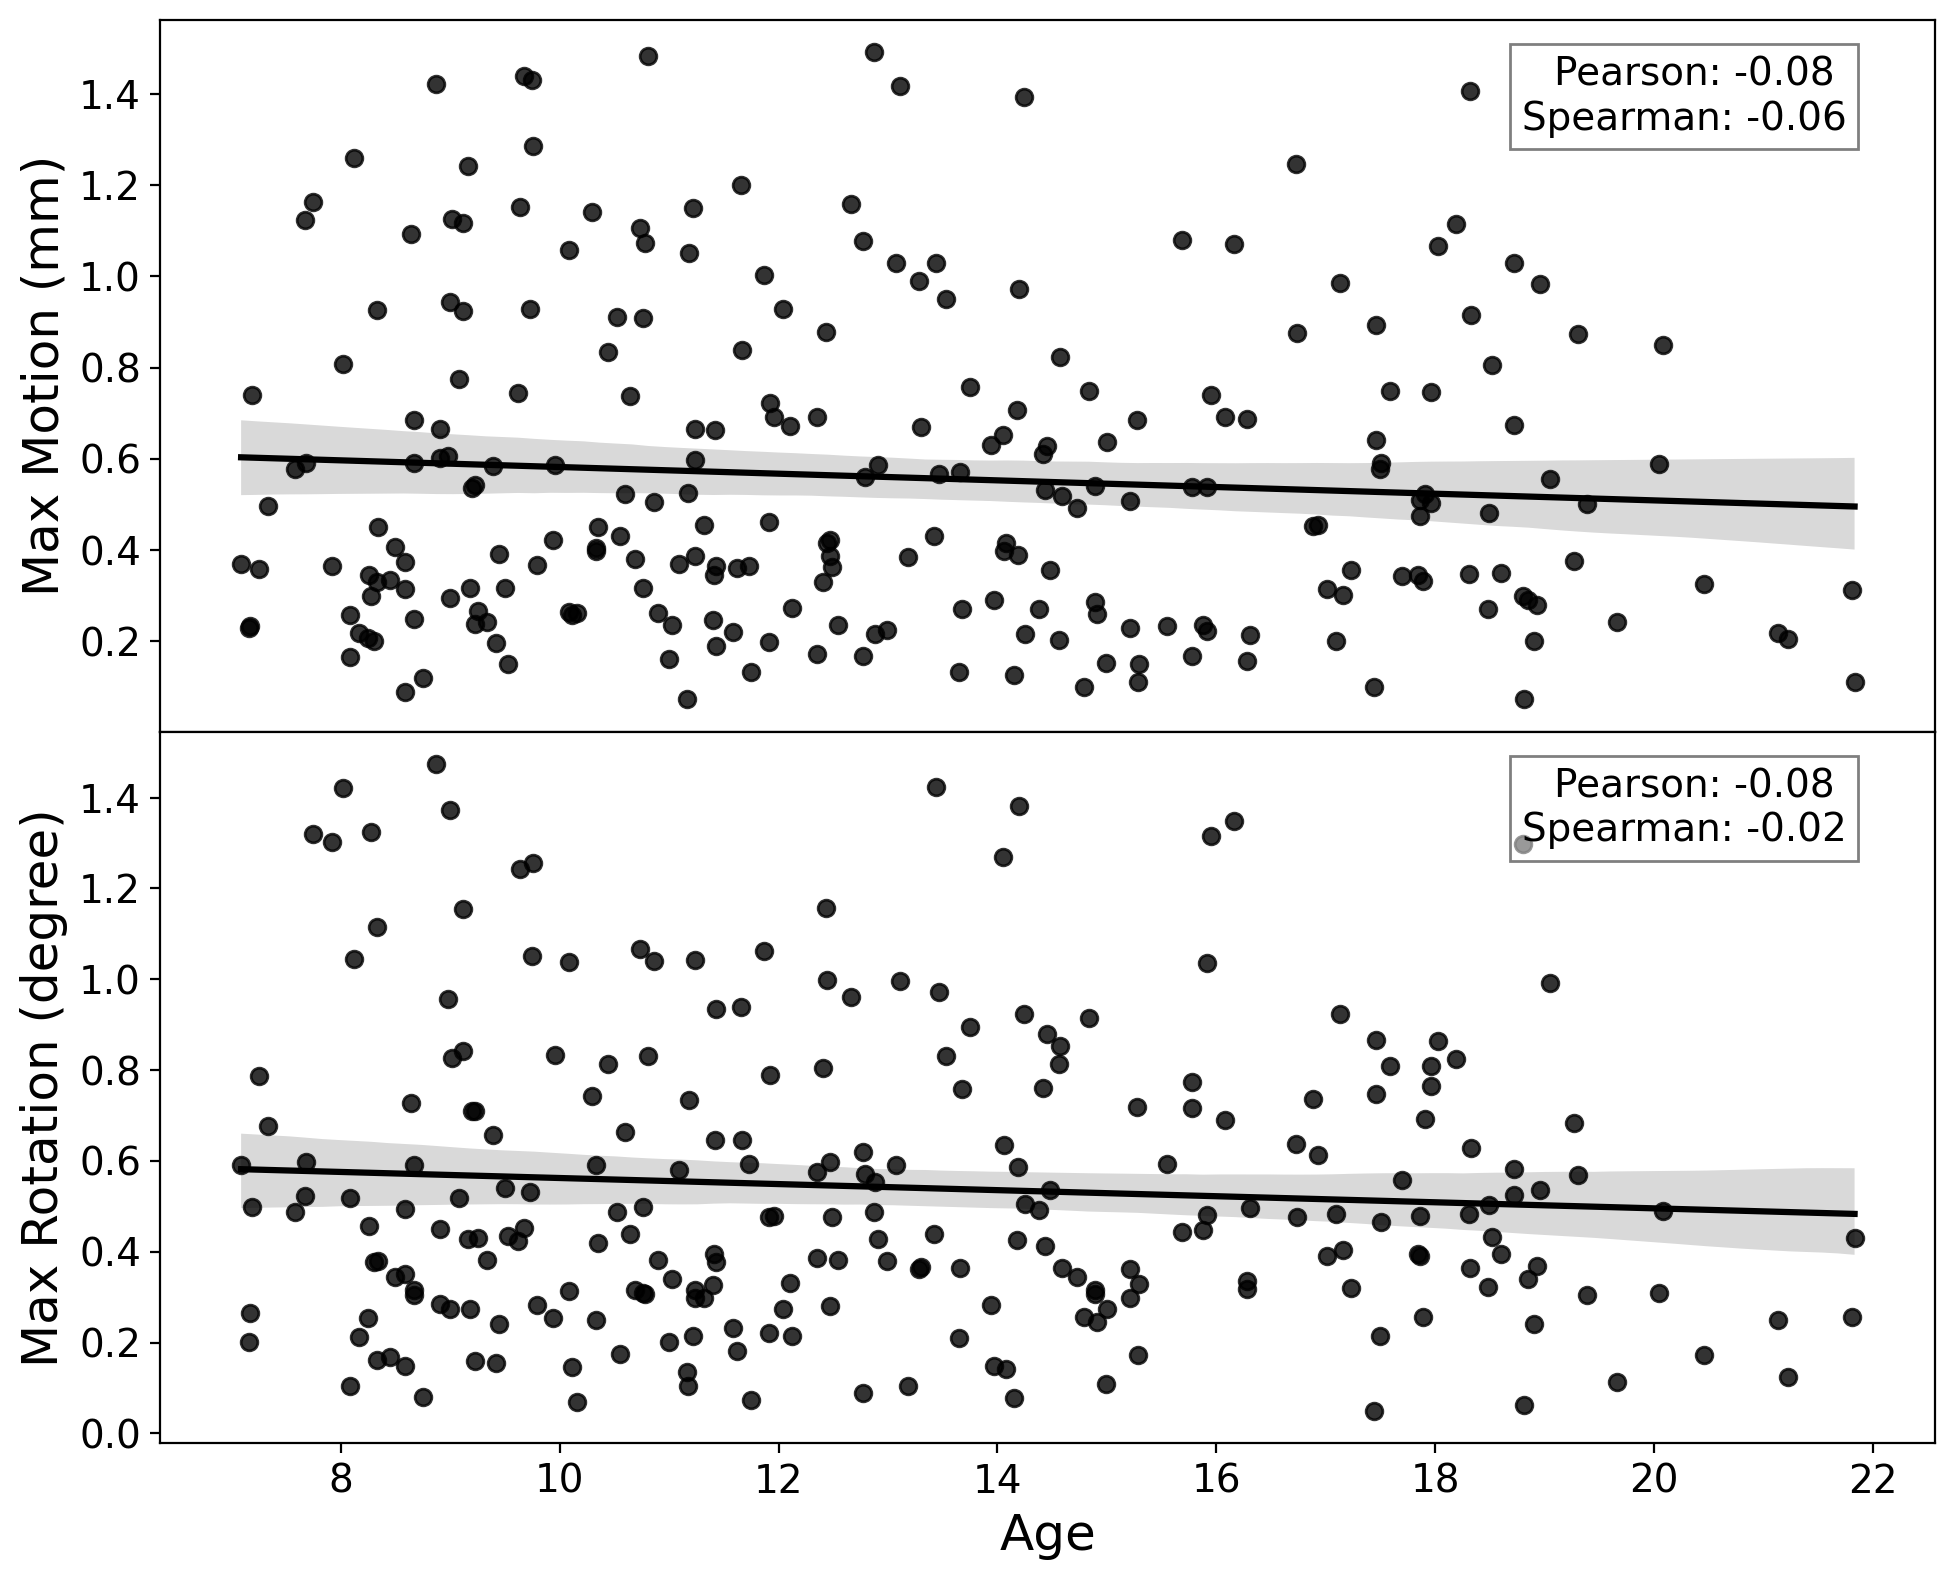

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Create a figure with two subplots sharing the x-axis and remove spacing between them
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=200, sharex=True, gridspec_kw={'hspace': 0})

# First plot
sns.regplot(data=df, y='Max Motion (mm)', x='Age', color='black', ax=ax1)
correlation_value = np.corrcoef([df['Age'].values, df['Max Motion (mm)'].values])[0, 1]
spearman = stats.spearmanr(df['Age'].values, df['Max Motion (mm)'].values).statistic
text = f'Pearson: {correlation_value:.2f} \nSpearman: {spearman:.2f}'
ax1.text(0.95, 0.95, text, ha='right', va='top', transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), size=14)
ax1.set_ylabel('Max Motion (mm)', fontsize=18)
ax1.label_outer()  # Only show bottom and left ticks and labels

# Second plot
sns.regplot(data=df, y=' Max Rotation (degree)', x='Age', color='black', ax=ax2)
correlation_value = np.corrcoef([df['Age'].values, df[' Max Rotation (degree)'].values])[0, 1]
spearman = stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic
text = f'Pearson: {correlation_value:.2f} \nSpearman: {spearman:.2f}'
ax2.text(0.95, 0.95, text, ha='right', va='top', transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), size=14)
ax2.set_xlabel('Age', fontsize=18)
ax2.set_ylabel('Max Rotation (degree)', fontsize=18)
ax2.label_outer()  # Only show bottom and left ticks and labels

# Increase the size of the x-axis ticks for both subplots
plt.xticks(fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size
ax2.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size


# Ensure the plots are aligned and labels are only on the bottom plot
plt.tight_layout()
plt.show()

PearsonRResult(statistic=-0.07816467839478249, pvalue=0.22569780902635514)


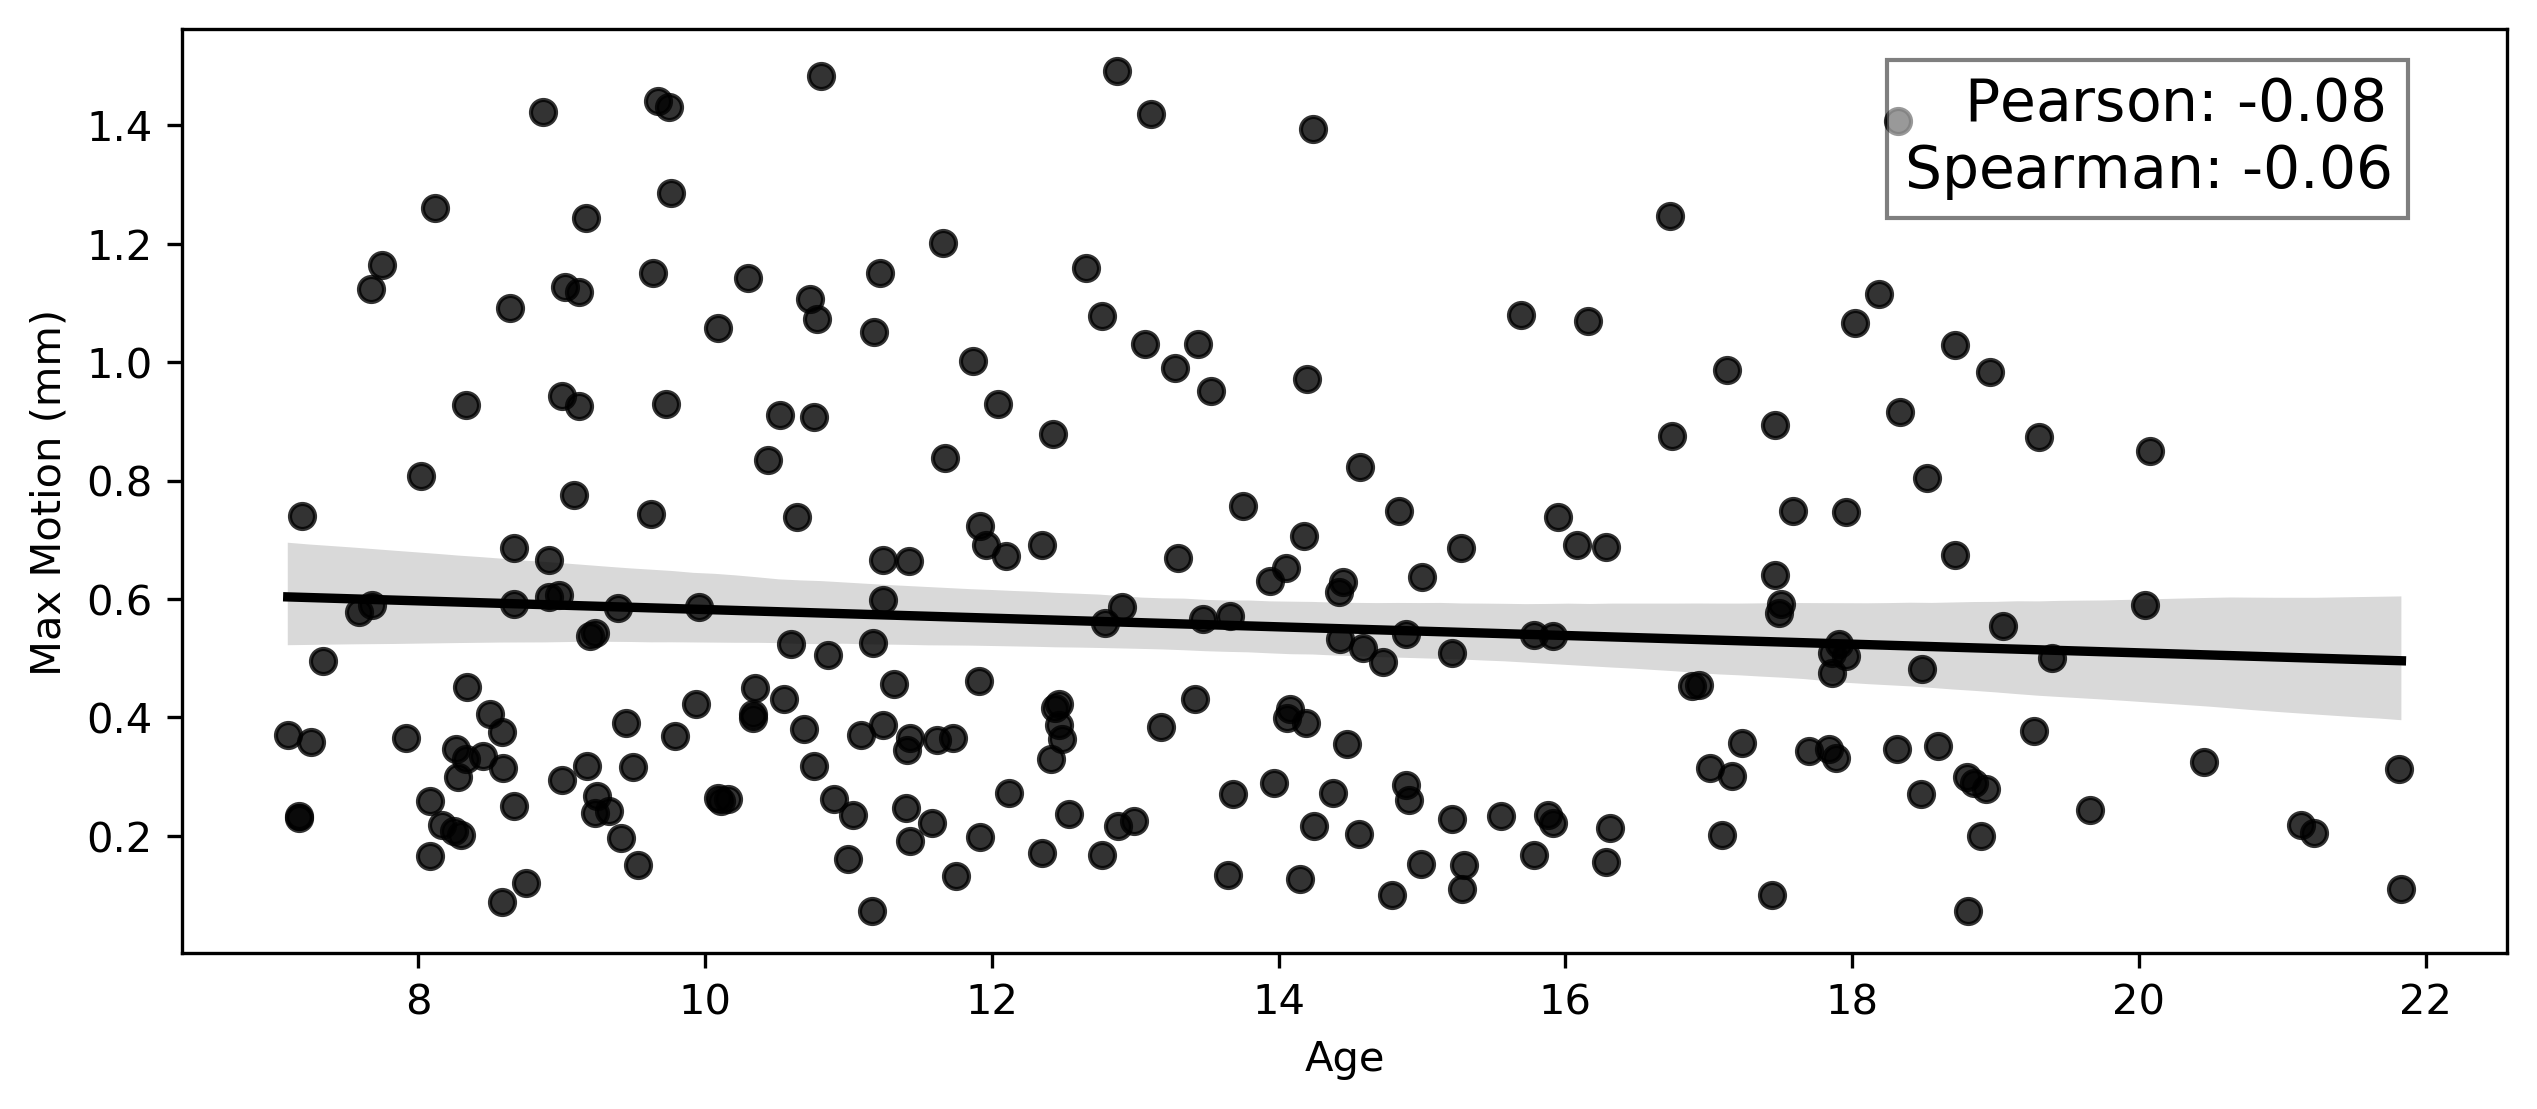

In [61]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Age'], df['Max Motion (mm)']))


sns.regplot(data=df, y='Max Motion (mm)', x='Age',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Max Motion (mm)'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Max Motion (mm)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),size=14)

#plt.colorbar(label='Age')
plt.xlabel(r'Age')
plt.ylabel(r'Max Motion (mm)')
#plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.07577363289671524, pvalue=0.24025606042877456)


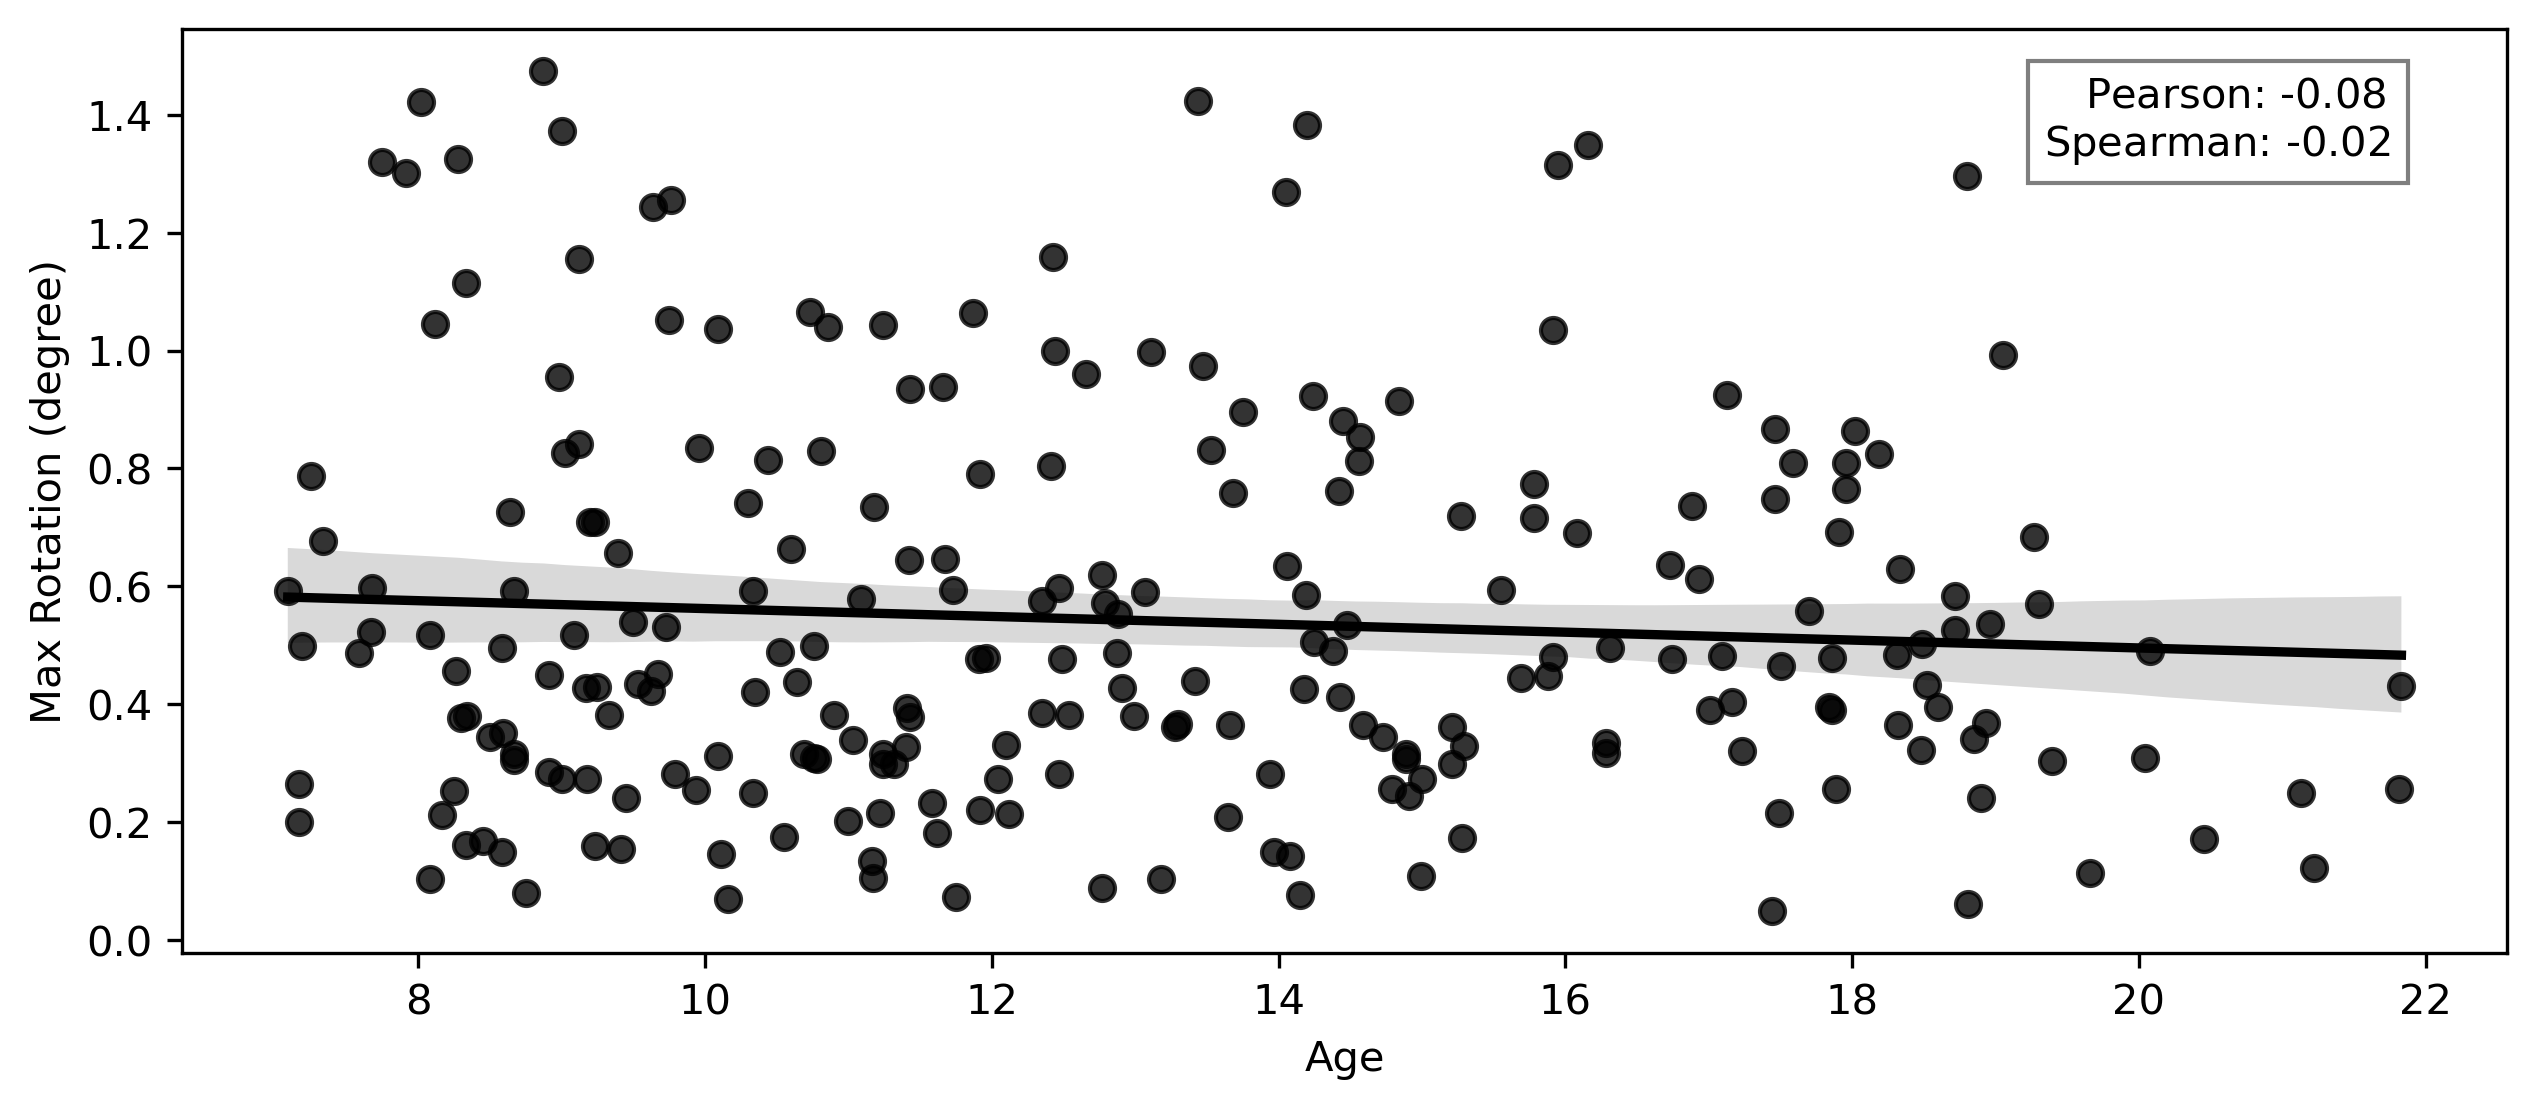

In [62]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Age'], df[' Max Rotation (degree)']))


sns.regplot(data=df, y=' Max Rotation (degree)', x='Age',color='black')

correlation_value = np.corrcoef([df['Age'].values, df[' Max Rotation (degree)'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.xlabel(r'Age')
plt.ylabel(r'Max Rotation (degree)')
#plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.07094917448095688, pvalue=0.2716016625816823)


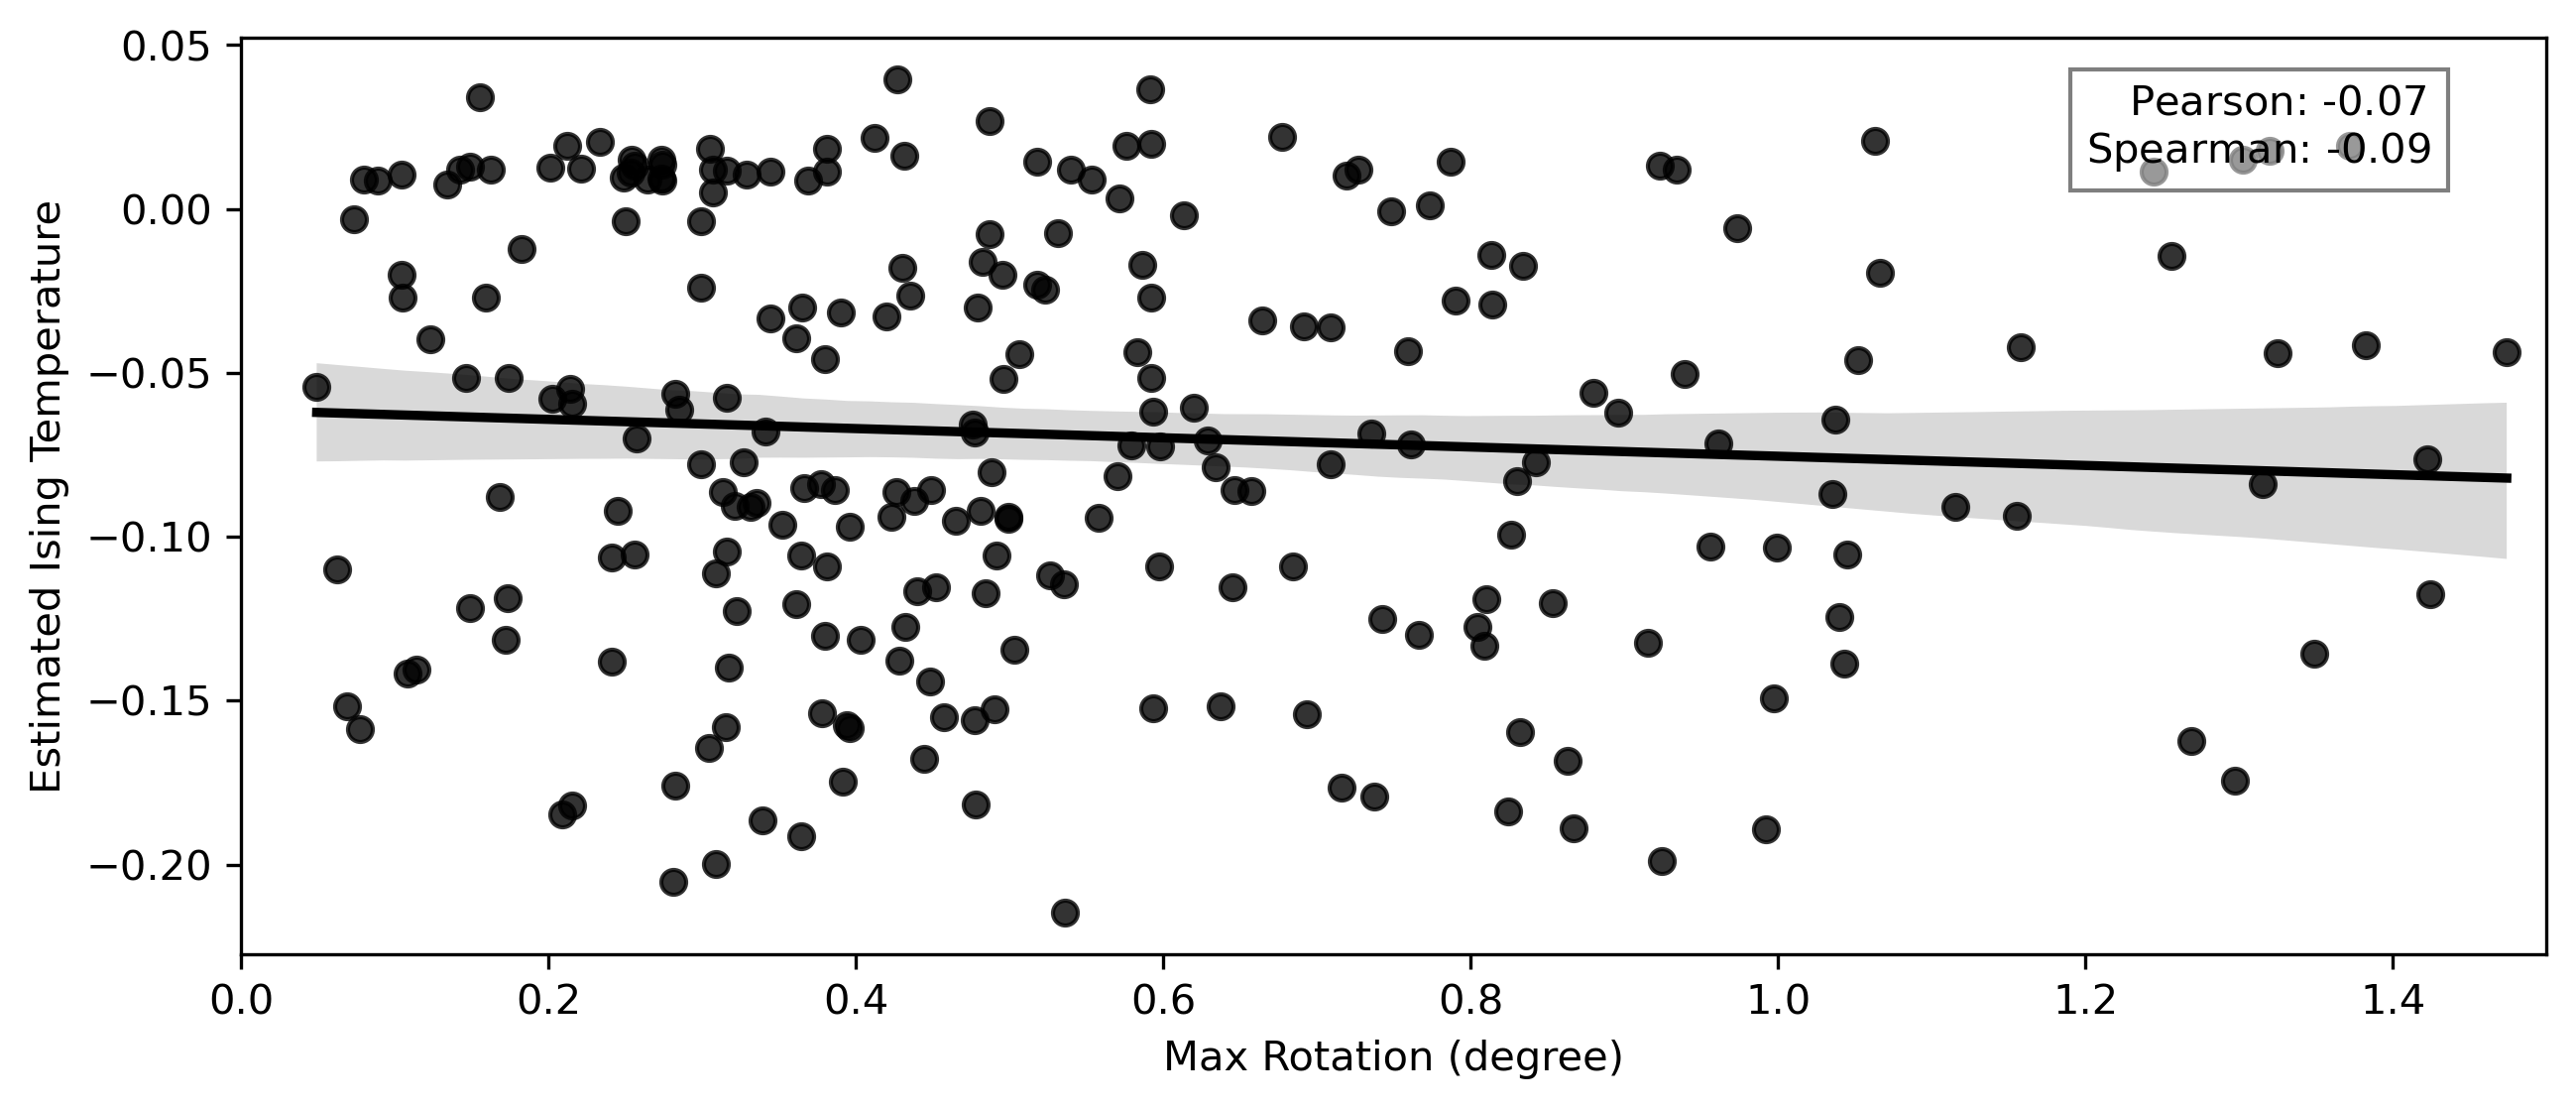

In [63]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Temperature'], df[' Max Rotation (degree)']))


sns.regplot(data=df, x=' Max Rotation (degree)', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Temperature'].values, df[' Max Rotation (degree)'].values])[0,1]
spearman = stats.spearmanr(df['Temperature'].values, df[' Max Rotation (degree)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.ylabel(r'Estimated Ising Temperature')
plt.xlabel(r'Max Rotation (degree)')
plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

PearsonRResult(statistic=-0.08031342528043613, pvalue=0.2131586323775493)


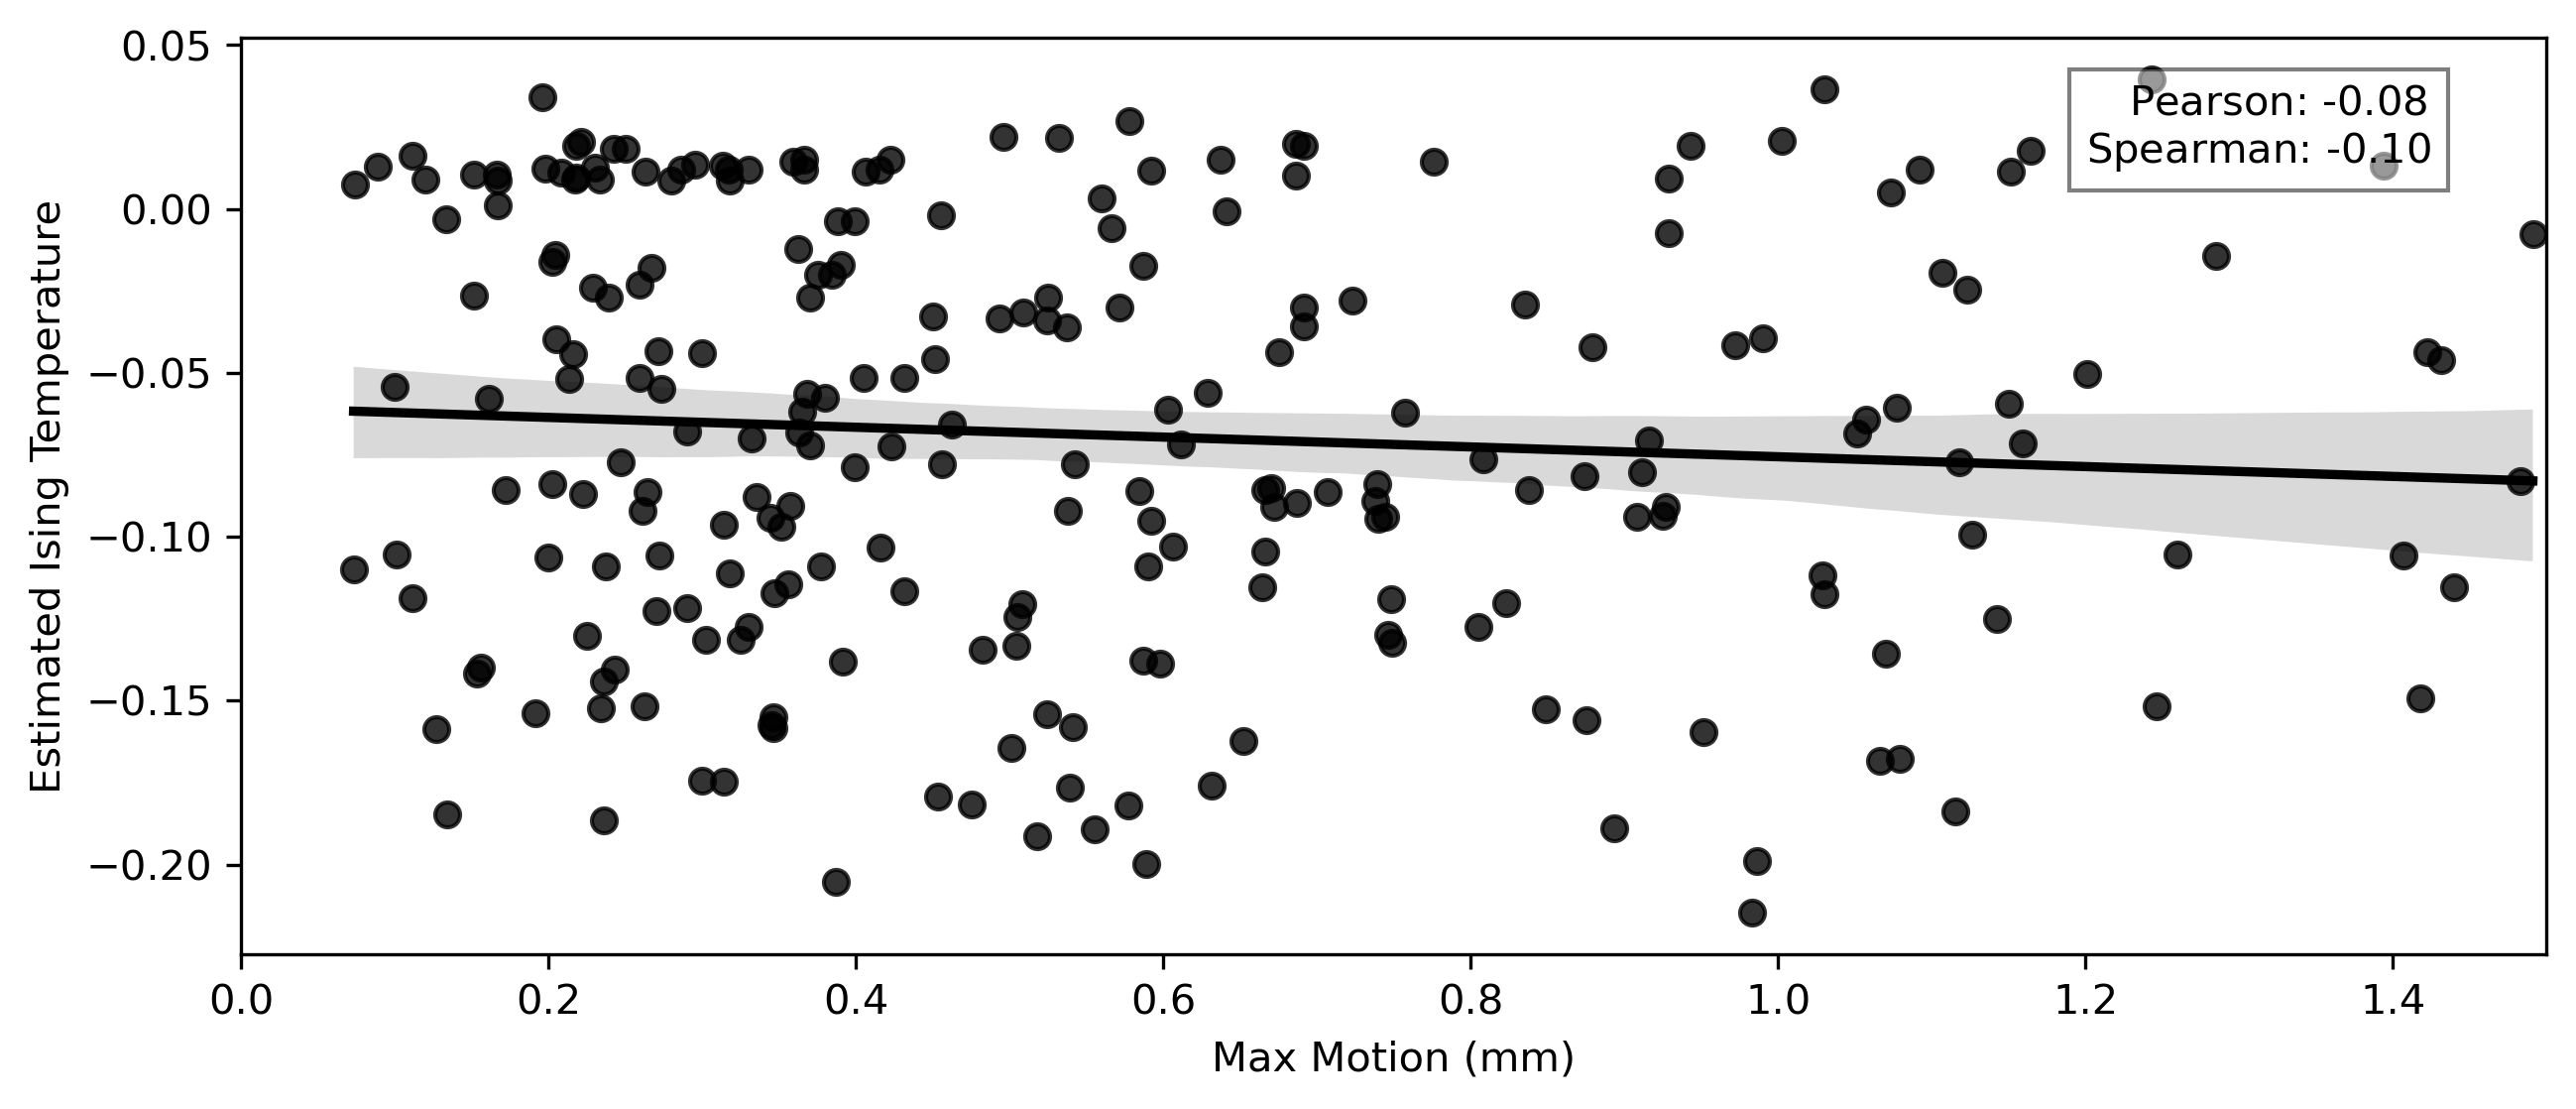

In [64]:
plt.figure(figsize=(10,4),dpi=300)
print(stats.pearsonr(df['Temperature'], df['Max Motion (mm)']))


sns.regplot(data=df, x='Max Motion (mm)', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Temperature'].values, df['Max Motion (mm)'].values])[0,1]
spearman = stats.spearmanr(df['Temperature'].values, df['Max Motion (mm)'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{}}$ \nSpearman: {spearman:.2f}$^{{}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

#plt.colorbar(label='Age')
plt.ylabel(r'Estimated Ising Temperature')
plt.xlabel(r'Max Motion (mm)')
plt.xlim(0,1.5)
#plt.ylim(1.8,2.5)

plt.show()

<Axes: xlabel='Temperature', ylabel='Max Motion (mm)'>

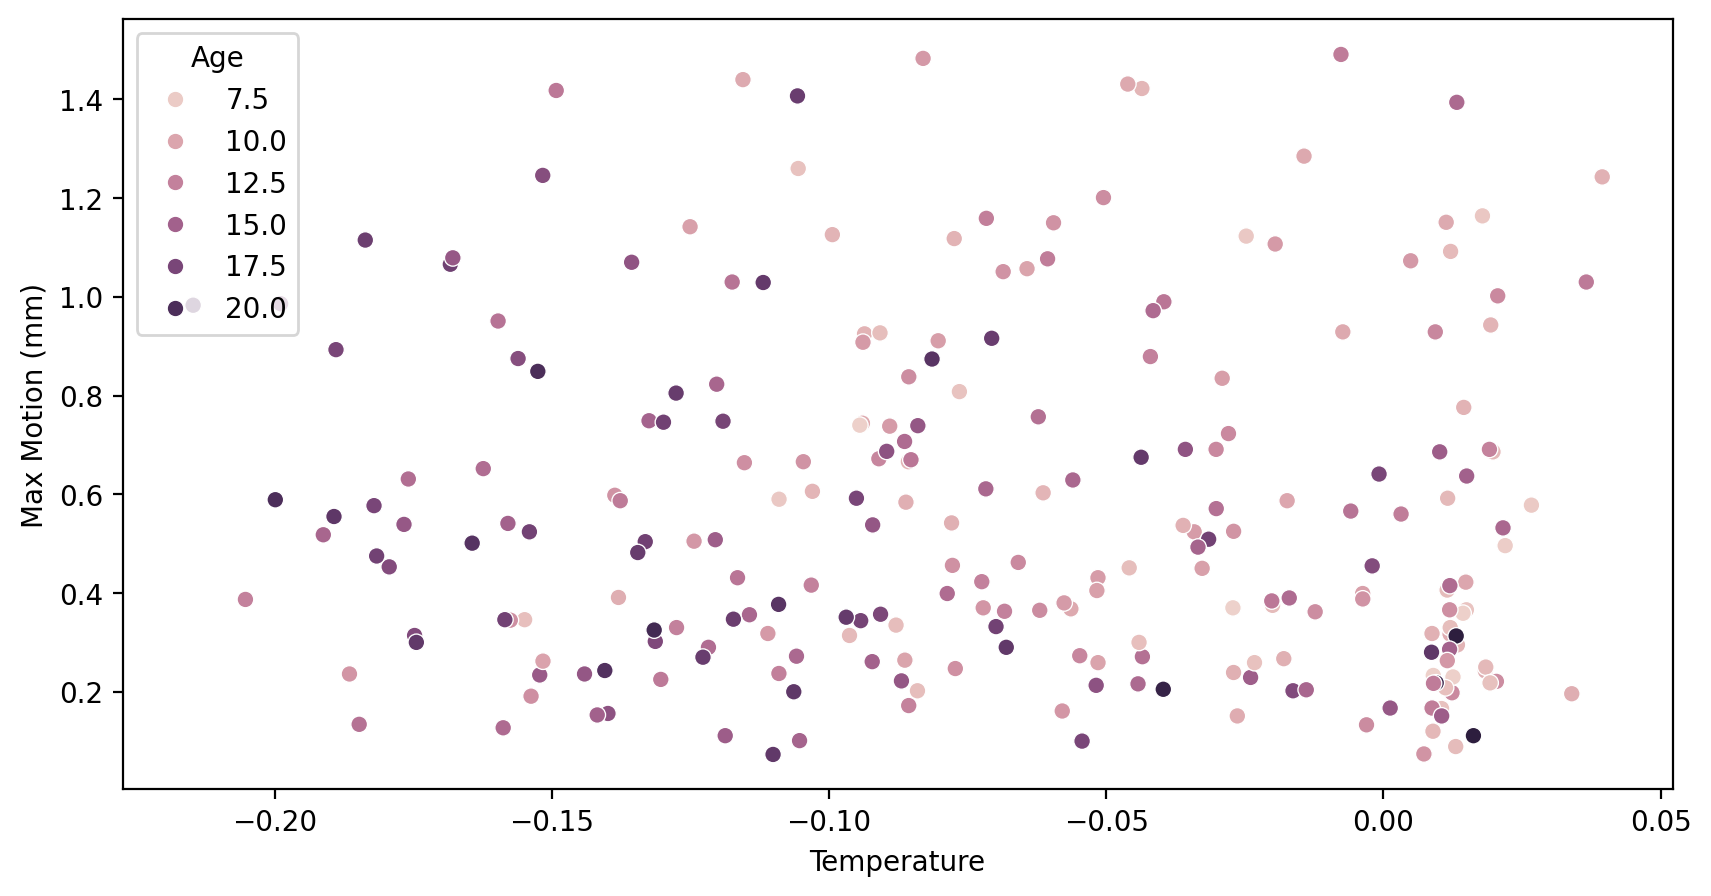

In [65]:
plt.figure(figsize=(10,5), dpi=200)
#sns.jointplot(data=df, x='Temperature', y='Max Motion (mm)', hue='Age')
#plt.xlim(2,2.2)
#plt.ylim(0,5)
sns.scatterplot(data=df, x='Temperature', y='Max Motion (mm)', hue='Age')

In [41]:
print('Pearson Temperature and Age = {}'.format(np.corrcoef([df['Temperature'], df['Age']])[0,1]))
print('Spearman Temperature and Age = {}'.format(stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic))


Pearson Temperature and Age = -0.41796127394424465
Spearman Temperature and Age = -0.432216664854911


In [42]:
print('Pearson Temperature and Max Motion = {}'.format(np.corrcoef([df['Temperature'], df['Max Motion (mm)']])[0,1]))
print('Spearman Temperature and Max Motion = {}'.format(stats.spearmanr(df['Temperature'].values, df['Max Motion (mm)'].values).statistic))


Pearson Temperature and Max Motion = -0.08031342528043611
Spearman Temperature and Max Motion = -0.10104456892499211


In [43]:
print('Pearson Temperature and Max Rotation = {}'.format(np.corrcoef([df['Temperature'], df[' Max Rotation (degree)']])[0,1]))
print('Spearman Temperature and Rotation = {}'.format(stats.spearmanr(df['Temperature'].values, df[' Max Rotation (degree)'].values).statistic))

Pearson Temperature and Max Rotation = -0.07094917448095682
Spearman Temperature and Rotation = -0.09263882964989181


In [44]:
print('Pearson Age and Max Motion = {}'.format(np.corrcoef([df['Age'], df[' Max Rotation (degree)']])[0,1]))
print('Spearman Age and Max Motion = {}'.format(stats.spearmanr(df['Age'].values, df[' Max Rotation (degree)'].values).statistic))

Pearson Age and Max Motion = -0.07577363289671529
Spearman Age and Max Motion = -0.024834171779752775


In [45]:
X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Age']] # 'DX'
y = df['Temperature']

# X = df[['Max Motion (mm)',' Max Rotation (degree)', 'Temperature']] # 'DX'
# y = df['Age']


X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

In [46]:
import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()
pred = mod.predict(X)


In [47]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     18.60
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           7.11e-11
Time:                        12:38:45   Log-Likelihood:                 15.240
No. Observations:                 242   AIC:                            -22.48
Df Residuals:                     238   BIC:                            -8.525
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.7992      0.039     20.640      0.000       0.723       0.876
Max Motion (mm)           -0.0851      0.073     -1.170      0.243      -0.228       0.058
 Max Rotation (degree)    -0.0652      0.078     -0.841      0.401      -0.218       0.088
Age                       -0.4345      0.059     -7.322      0.000      -0.551      -0.318
==============================================================================
Omnibus:                        5.861   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                3.375
Skew:                          -0.012   Prob(JB):                        0.185
Kurtosis:                       2.422   Cond. No.                         7.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
stats.pearsonr(df['Age'].values, df['Temperature'].values)

PearsonRResult(statistic=-0.4179612739442448, pvalue=1.191497884009048e-11)

In [49]:
stats.spearmanr(df['Age'].values, df['Temperature'].values)

SignificanceResult(statistic=-0.432216664854911, pvalue=1.9550287892839637e-12)

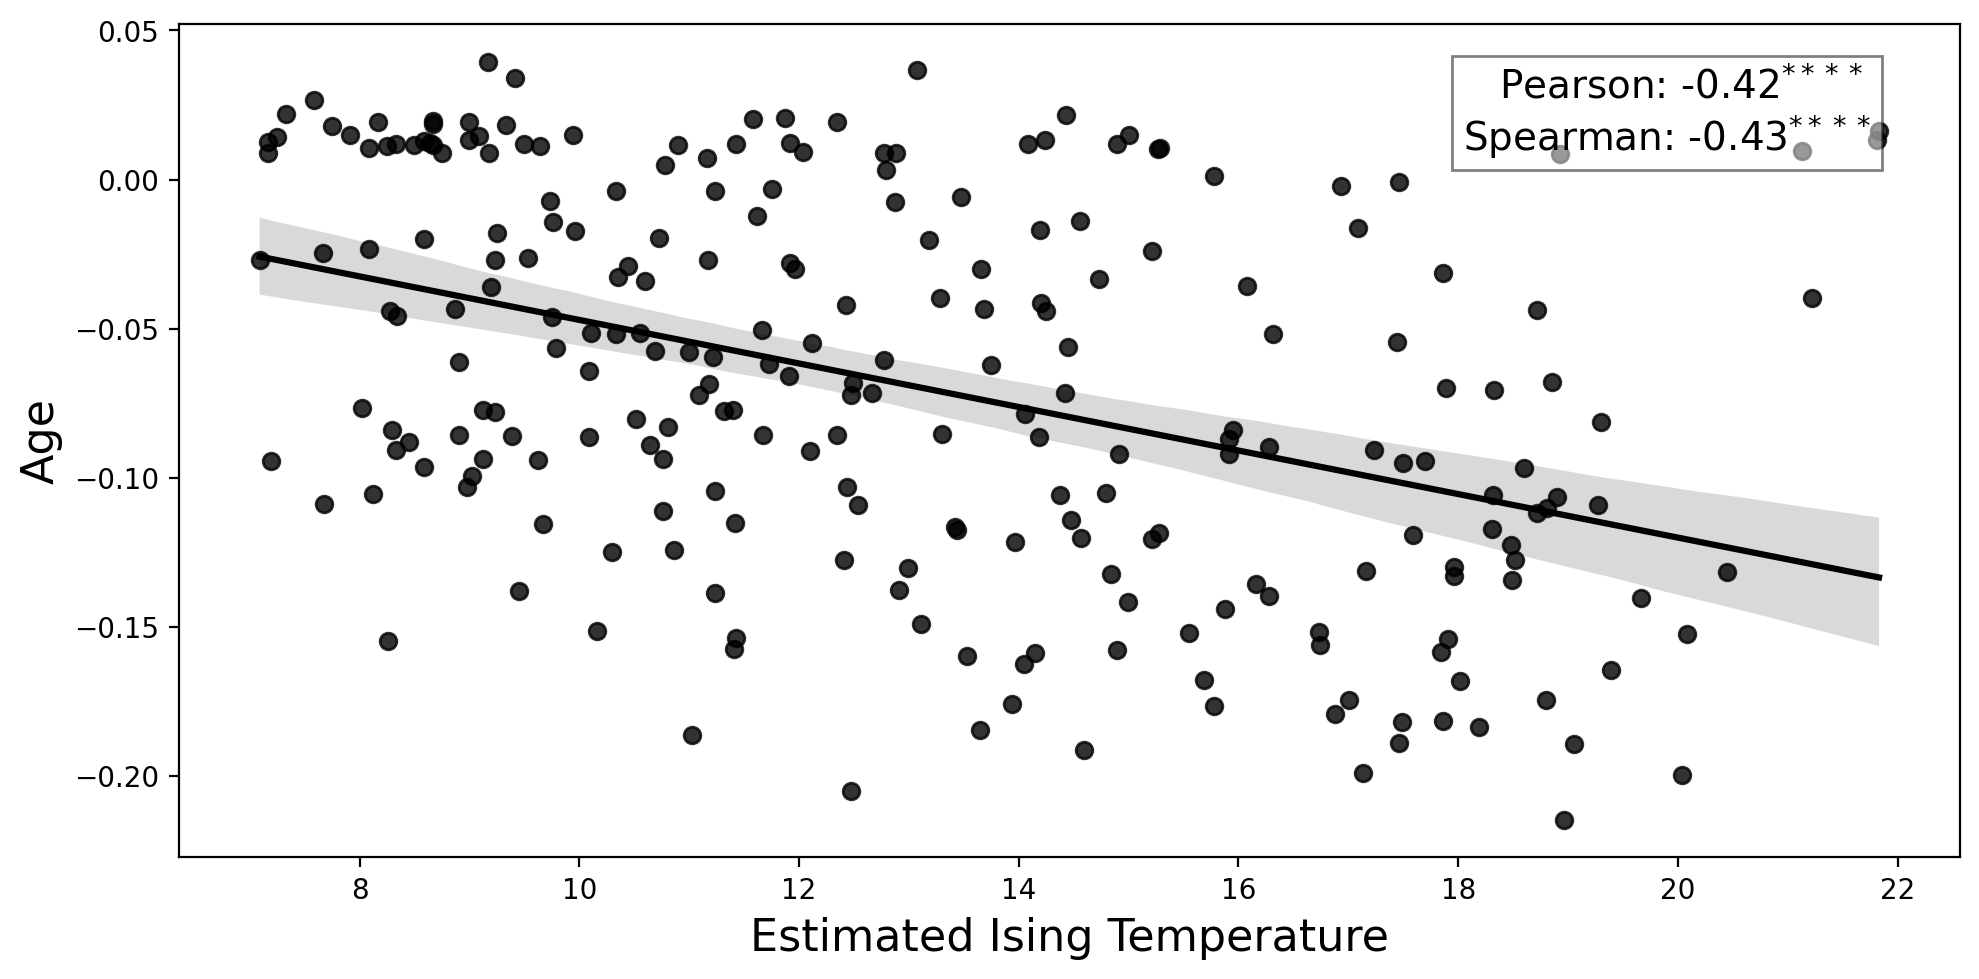

In [50]:
from scipy import stats

plt.figure(figsize=(10,5),dpi=200)
sns.regplot(data=df, x='Age', y='Temperature',color='black')

correlation_value = np.corrcoef([df['Age'].values, df['Temperature'].values])[0,1]
spearman = stats.spearmanr(df['Age'].values, df['Temperature'].values).statistic

text = f'Pearson: {correlation_value:.2f}$^{{****}}$ \nSpearman: {spearman:.2f}$^{{****}}$'

# Adding text box with correlation value
plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),size=14)

#plt.ylim(1.9, 2.4)
plt.xlabel('Estimated Ising Temperature', size=16)
plt.ylabel(r'Age', size=16)
plt.tight_layout()
plt.show()

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_88478/1998254343.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age Group', y='Dist_Temperature', data=df, palette='viridis_r')


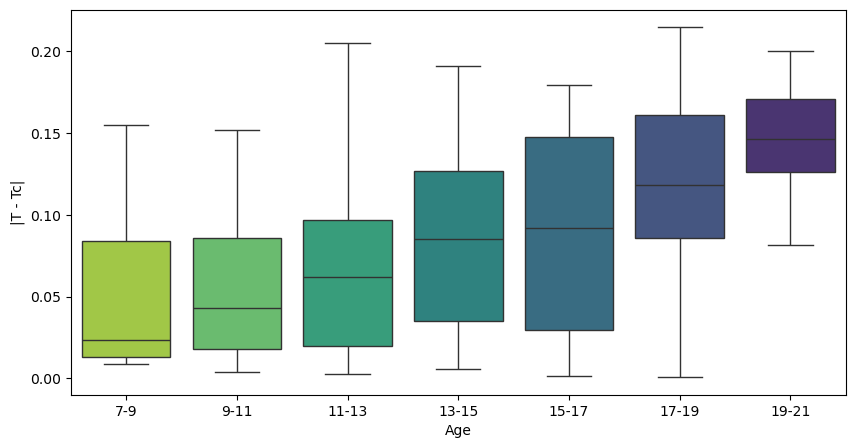

In [76]:
# Define the age bins and their labels
bins = [7, 9, 11, 13, 15, 17, 19, 21]
labels = ['7-9', '9-11', '11-13', '13-15', '15-17', '17-19', '19-21']

# Create a new column 'Age Group' with the binned ages
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Dist_Temperature'] = abs(df['Temperature'])

# Plot the box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Age Group', y='Dist_Temperature', data=df, palette='viridis_r')
plt.ylabel('|T - Tc|')
plt.xlabel('Age')
plt.show()


In [78]:
print('Age Groups percentage', df['Age Group'].value_counts(normalize=True) * 100)


Age Groups percentage Age Group
9-11     20.168067
11-13    19.747899
13-15    16.386555
7-9      15.546218
17-19    15.126050
15-17     9.663866
19-21     3.361345
Name: proportion, dtype: float64


In [93]:
df.shape

(242, 7)

In [91]:
df = adhd_ingestion(dx=0, max_m=1.5)

from scipy.stats import bootstrap

# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap = (df['Age'].values, df['Temperature'].values)
results = bootstrap(data_for_bootstrap, np.corrcoef, paired=True,confidence_level=0.95, n_resamples=1000, method='BCa')


# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")


# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples = results.bootstrap_distribution[1,0]


adhd = adhd_ingestion(dx=1, max_m=1.5)


# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap_adhd = (adhd['Age'].values, adhd['Temperature'].values)
results_adhd = bootstrap(data_for_bootstrap, np.corrcoef, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval_adhd = results_adhd.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples_adhd = results_adhd.bootstrap_distribution[1,0]



/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_88478/3861590456.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_88478/3861590456.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.ad

TypeError: bootstrap() got an unexpected keyword argument 'n'

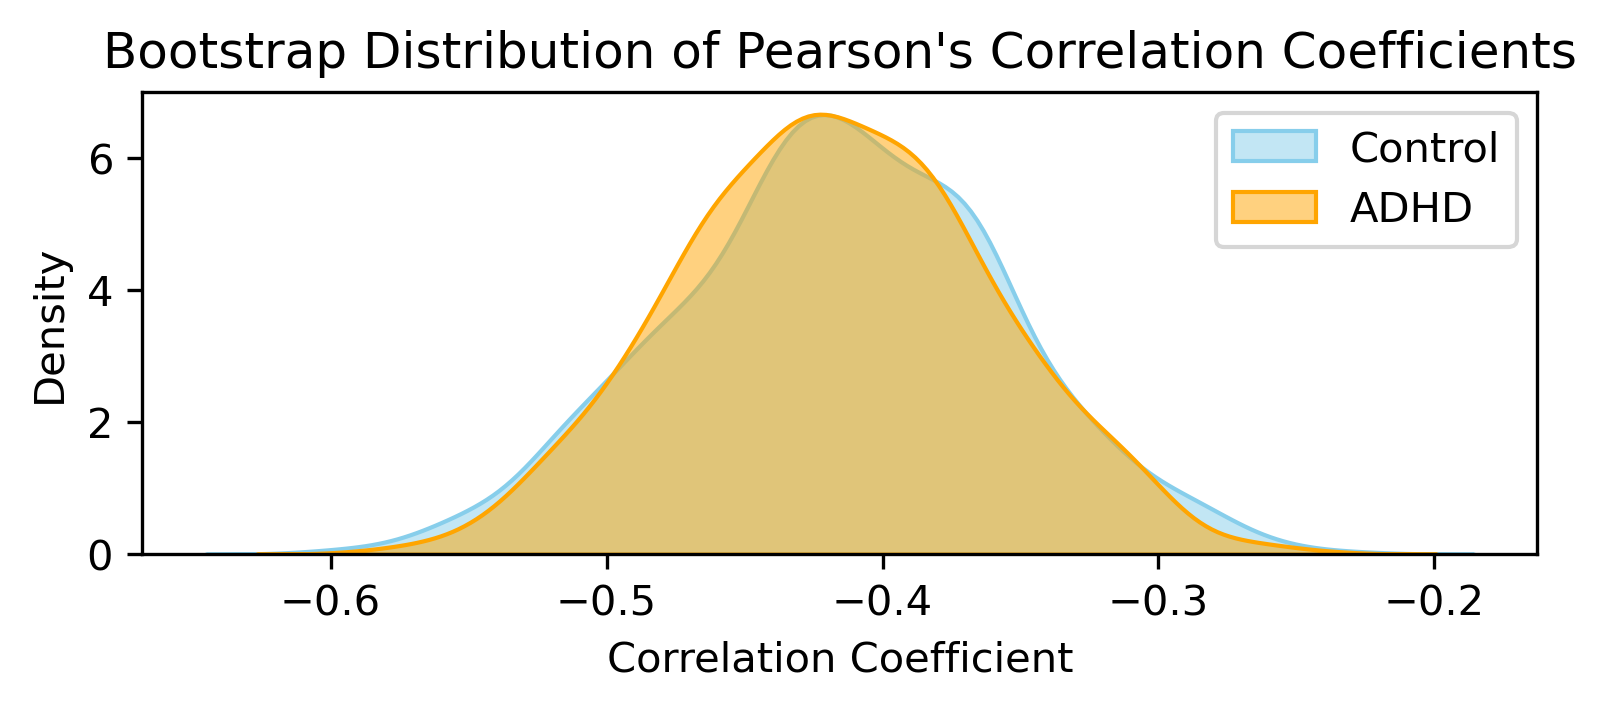

In [84]:
plt.figure(dpi=300, figsize=(6,2))
sns.kdeplot(bootstrap_samples, fill=True, color="skyblue", alpha=0.5, linewidth=1, label='Control')
sns.kdeplot(bootstrap_samples_adhd, fill=True,color='orange', alpha=0.5, linewidth=1, label='ADHD')

plt.title('Bootstrap Distribution of Pearson\'s Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

In [75]:
df = adhd_ingestion(dx=0, max_m=1.5)

from scipy.stats import bootstrap
# Define a function to calculate the correlation coefficient
def spearman(sample, sample2):
    statistic = stats.spearmanr(sample, sample2).statistic
    return statistic


# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap = (df['Age'].values, df['Temperature'].values)
results = bootstrap(data_for_bootstrap, spearman, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the confidence interval
conf_interval = results.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples = results.bootstrap_distribution

adhd = adhd_ingestion(dx=1, max_m=1.5)

from scipy.stats import bootstrap


# Prepare the data for bootstrap (it requires a tuple of arrays)
data_for_bootstrap_adhd = (adhd['Age'].values, adhd['Temperature'].values)
results_adhd = bootstrap(data_for_bootstrap, spearman, paired=True,confidence_level=0.95, n_resamples=1000, method='basic')


# Extract the confidence interval
conf_interval_adhd = results_adhd.confidence_interval

print(f"95% Confidence interval for the correlation: {conf_interval}")

# Extract the bootstrap samples
bootstrap_samples_adhd = results_adhd.bootstrap_distribution


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_25634/3791236122.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_25634/3791236122.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.ad

95% Confidence interval for the correlation: ConfidenceInterval(low=-0.4987902147781503, high=-0.28019324362774506)
95% Confidence interval for the correlation: ConfidenceInterval(low=-0.4987902147781503, high=-0.28019324362774506)


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_25634/3791236122.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_25634/3791236122.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.ad

95% Confidence interval for the correlation: ConfidenceInterval(low=-0.4987902147781503, high=-0.28019324362774506)


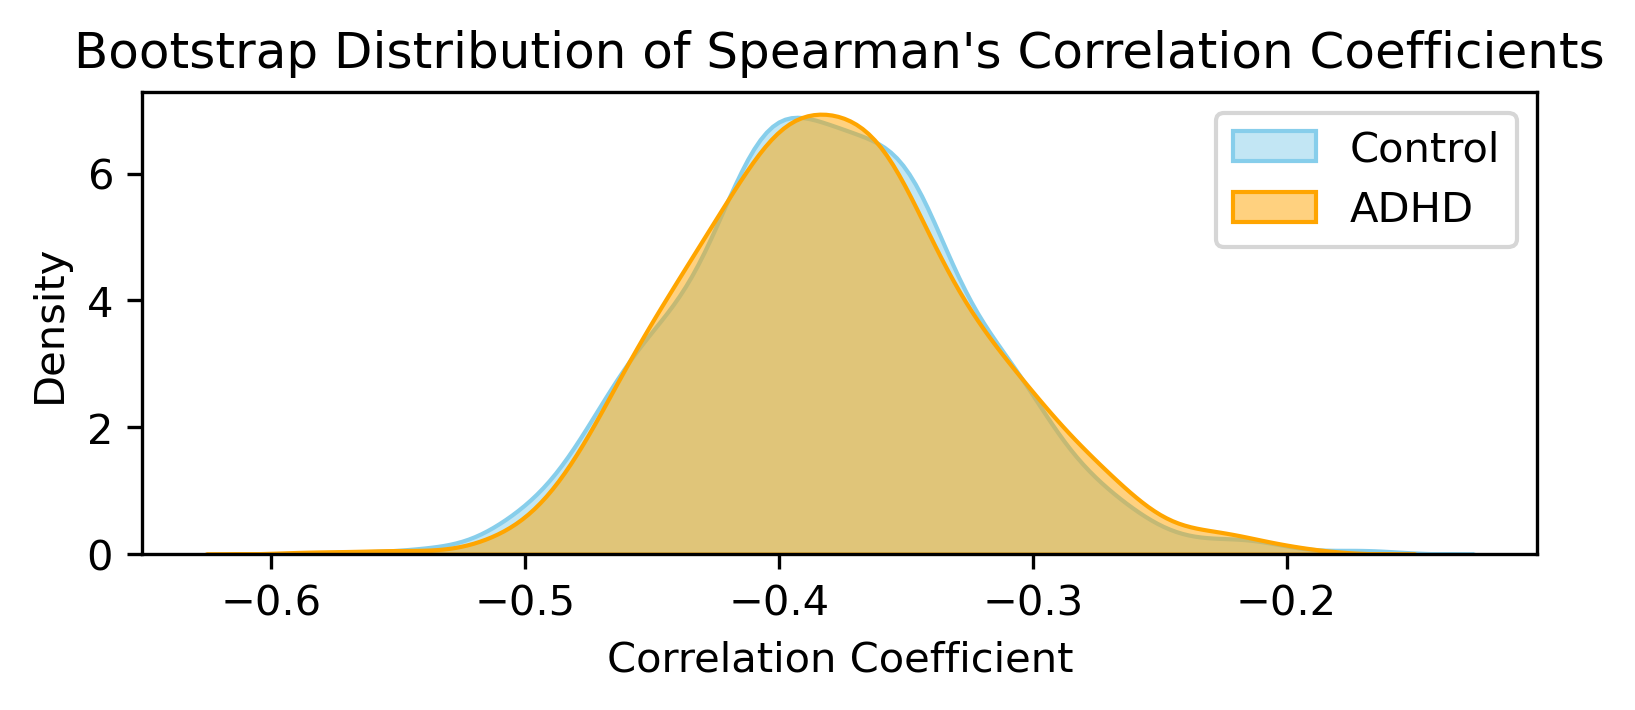

In [76]:
plt.figure(dpi=300, figsize=(6,2))
sns.kdeplot(bootstrap_samples, fill=True, color="skyblue", alpha=0.5, linewidth=1, label='Control')
sns.kdeplot(bootstrap_samples_adhd, fill=True,color='orange', alpha=0.5, linewidth=1, label='ADHD')

plt.title('Bootstrap Distribution of Spearman\'s Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

In [77]:
stats.ttest_ind(bootstrap_samples, bootstrap_samples_adhd)

TtestResult(statistic=-0.7180045654668508, pvalue=0.47283841557121065, df=1998.0)

## Analysis of DX

In [31]:
df_dx1 = adhd_ingestion(dx=1, max_m=1.5)
df_dx2 = adhd_ingestion(dx=2, max_m=1.5)
df_dx3 = adhd_ingestion(dx=3, max_m=1.5)

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49227/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49227/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_49227/790222714.py:3: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Post-Grad/adhd_dataset_gordon.csv')


In [32]:
df = df[df.Age <= 10]

df_dx1 = df_dx1[df_dx1.Age <= 10]
df_dx2 = df_dx2[df_dx2.Age <= 10]
df_dx3 = df_dx3[df_dx3.Age <= 10]

In [281]:
print(df.shape)
print(df_dx1.shape)
print(df_dx2.shape)
print(df_dx3.shape)

(64, 7)
(24, 7)
(1, 7)
(11, 7)


In [282]:
all_arr = [df['Temperature'], df_dx1['Temperature'], df_dx2['Temperature'], df_dx3['Temperature']]

Text(0.5, 0, 'DX')

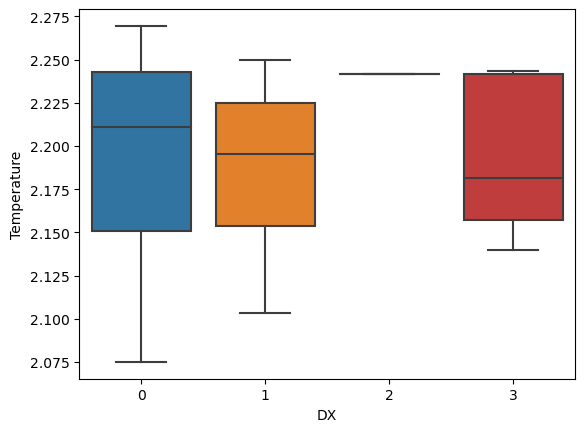

In [283]:
sns.boxplot(all_arr)
plt.ylabel('Temperature')
plt.xlabel('DX')

In [284]:
all_arr = [df['Temperature'], pd.concat([df_dx1, df_dx2,df_dx3])['Temperature']]

In [285]:
stats.ttest_ind(all_arr[0], all_arr[1])

Ttest_indResult(statistic=0.838767579085059, pvalue=0.40364102807491475)

Text(0.5, 0, 'DX')

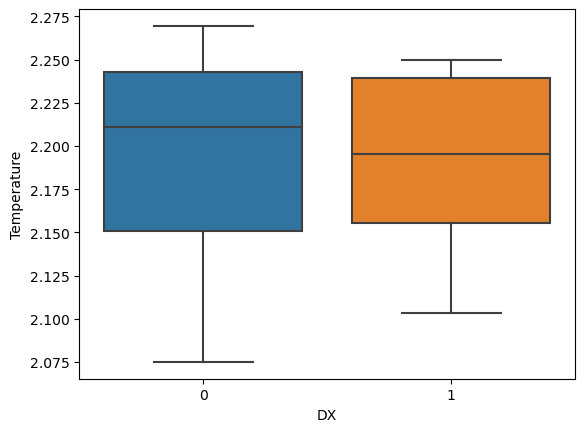

In [286]:
sns.boxplot(all_arr)
plt.ylabel('Temperature')
plt.xlabel('DX')

In [185]:
all_arr = [df[' Max Rotation (degree)'], df_dx1[' Max Rotation (degree)'], df_dx2[' Max Rotation (degree)'], df_dx3[' Max Rotation (degree)']]

In [186]:
sns.boxplot(df_all)
plt.ylabel('Max Rotation (degree)')
plt.xlabel('DX')

NameError: name 'df_all' is not defined

## Constency over the same subject

In [38]:
df = runs(dx=0, max_m=1)

/Users/rodrigo/Post-Grad/Ising_GNN/utils.py:356: FutureWarning: The default value of regex will change from True to False in a future version.
  motion['Subject'] = motion['Subject'].str.replace(r'^(0+)', '').fillna('0')


In [39]:
df = df.set_index(['Institution', 'Subject', 'Run']) 

In [40]:
std = df.groupby(level=['Institution','Subject']).std()['Temperature'].dropna()
motion = df.groupby(level=['Institution','Subject']).mean()['Max Motion (mm)'].dropna()

common_indices = motion.index.intersection(std.index)
motion = motion.loc[common_indices]

Pearson Temperature and Age = 0.16194416855935584


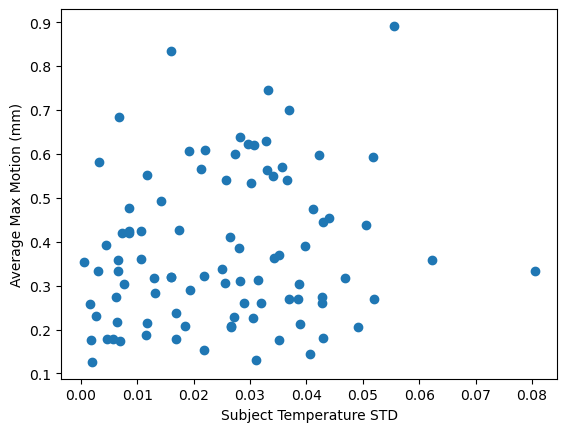

In [41]:
plt.scatter(std,motion)
plt.ylabel('Average Max Motion (mm)')
plt.xlabel('Subject Temperature STD')

print('Pearson STD Temperature and Average Max Motion (mm) = {}'.format(np.corrcoef([std, motion])[0,1]))

Text(0.5, 0, 'Subject Temperature STD')

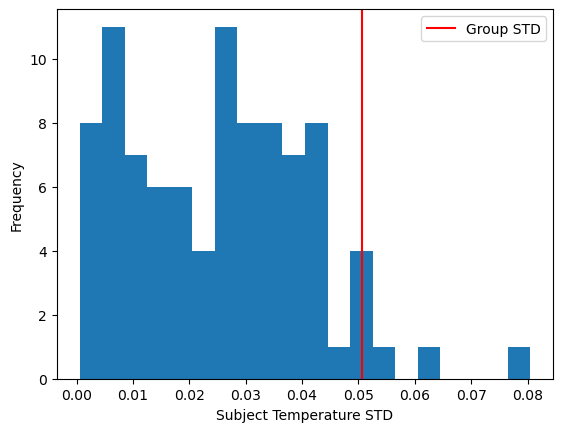

In [42]:
plt.hist(std, bins=20)
#plt.hist(motion)
plt.axvline(df['Temperature'].std(),color='red', label='Group STD')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Subject Temperature STD')

Text(0, 0.5, 'Subject Temperature STD')

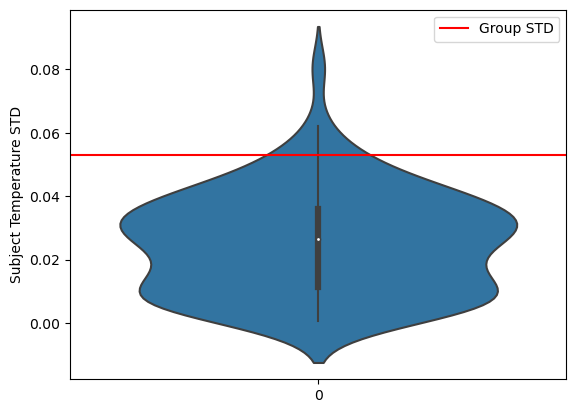

In [101]:
sns.violinplot(std)
#plt.hist(motion)
plt.axhline(df['Temperature'].std(),color='red', label='Group STD')
plt.legend()
#plt.ylabel('Frequency')
plt.ylabel('Subject Temperature STD')